In [98]:
# Written to take advantage of local variables and other time optimization tricks
# Later, this will be written using numpy for extra optimization (likely after writing the data feeder)

# To-do: COM, dealing with extended masses (halo), energy of extended masses (halo)

#  -------------------------------------Initial conditions-------------------------------------
import random
import math
# Need to find a way to import the examples file

sqrt = math.sqrt
rand = random.uniform

system = 'mks'
if system == 'cgs':
    G = 6.6743e-8
elif system == 'mks':
    G = 6.67408e-11

do_random = 0

# Only data inputs it should need. Will be global at first.
positions, velocities, masses = [[0,0,0],[0,1.49e11,0],[0,0.72*1.49e11,0]], [[0,0,0],[-29690,0,0],[-34720,0,0]], [1.989e30,5.97e24,4.867e24]

In [99]:
#       ---------------------------------Primary Functions---------------------------------
def initializeRandom(stars, posr, velr, massr):
    posit = [[rand(posr[0],posr[1]) for i in range(3)] for j in range(stars)] #Nested list comprehensions!
    veloc = [[rand(velr[0],velr[1]) for i in range(3)] for j in range(stars)]
    mas = [rand(massr[0],massr[1]) for i in range(stars)]
    return posit, veloc, mas

def centerOfMass(pos,mass):
    xupper, yupper, zupper, lower = 0,0,0,0
    for i in range(len(pos)):
        xupper += pos[i][0] * mass[i]
        yupper += pos[i][1] * mass[i]
        zupper += pos[i][2] * mass[i]
        lower += mass[i]
    return [xupper/lower,yupper/lower,zupper/lower]
    
def findEnergies(pos,mass,vel,time,com):
    kinetic = sum([0.5*mass[i]*mag(vel[i])**2 for i in range(len(pos))])
    potential = 0
    for initial in range(len(mass)):
        for affective in range(initial+1,len(mass)):
            potential += -G * mass[initial] * mass[affective] / findDistance(pos[initial],pos[affective])
    
    f = open('data.txt','a')
    f.write('%.5f'%time + ' ' + str(kinetic)+ ' ' + str(potential) + ' ' + str(kinetic+potential)  + ' ' + ' '.join([str(c) for c in com]) + ' ' +  ' '.join('%.5f %.5f %.5f'%(p[0],p[1],p[2]) for p in pos)+' ' + ' '.join('%.5f %.5f %.5f'%(v[0],v[1],v[2]) for v in vel)+'\n')
    f.close()

def findDistance(a,b, returnDiff=0):
    #a and b are position sets, like [1,4.3,5] and [5,4,-7], because variable scope
    differences = [a[i] - b[i] for i in range(3)]
    distance = sqrt(sum([j**2 for j in differences]))
    if returnDiff == 0:
        return distance
    else:
        return distance, differences[0], differences[1], differences[2]

#Still by far the longest function
def updateAccel(pos, mass):
    accelerations = [[0,0,0] for j in range(len(mass))] #For some reason [[0,0,0]]*len(mass) didn't work?
    
    mindist = -1
    for initial in range(len(mass)-1): #Last body will already have been done by everything else
        for affective in range(initial+1,len(mass)):
            dist, xdist, ydist, zdist = findDistance(pos[initial],pos[affective],1)
            
            if dist < mindist or mindist == -1: #This short circuits before -1, saving some time
                mindist = dist
            
            force = G*mass[initial]*mass[affective]/(dist ** 3)
            
            acc_initial = force/mass[initial]
            acc_affective = force/mass[affective] #Could do a memory/time tradeoff here
            
            accelerations[initial][0] += acc_initial * -xdist
            accelerations[initial][1] += acc_initial * -ydist
            accelerations[initial][2] += acc_initial * -zdist
            
            accelerations[affective][0] += acc_affective * xdist
            accelerations[affective][1] += acc_affective * ydist
            accelerations[affective][2] += acc_affective * zdist
    
    return mindist, accelerations

def vHalf(vel, a, t):
    v = vel #Is this necessary?
    for i in range(len(vel)):
        v[i][0] += 0.5*a[i][0]*t
        v[i][1] += 0.5*a[i][1]*t
        v[i][2] += 0.5*a[i][2]*t
    return v

def updatePositions(pos,v_half,t):
    for i in range(len(pos)):
        pos[i][0] += v_half[i][0]*t
        pos[i][1] += v_half[i][1]*t
        pos[i][2] += v_half[i][2]*t
    
    return pos

def updateVelocities(v_half,a,t):
    v = v_half
    for i in range(len(v_half)):
        v[i][0] += 0.5*a[i][0]*t
        v[i][1] += 0.5*a[i][1]*t
        v[i][2] += 0.5*a[i][2]*t
        
    return v

def mag(n):
    return sqrt(sum([x**2 for x in n]))

In [104]:
#       ---------------------------------------Setup---------------------------------------
if do_random == 1:
    positions, velocities, masses = initializeRandom(10,[-3e9,2.5e9],[0,1e3],[1e10,5e10]) #Stars, position range, velocity range, mass range

#       -------------------------------------Main Loop-------------------------------------

def leapfrog(p, v, m, nloops, pos_history=False): 
    # p = positions; v = velocities; m = masses; nloops = times run
    time = 0
    mindist, accel = updateAccel(p,m)
    f = open('data.txt','w') #Clears data file
    f.close()
    
    percent_indicators = nloops//5
    
    if pos_history:
        pos_hist = [p]
    
    # Finds acceleration using Newtonian gravity and finds minimum distance between bodies
    for L in range(nloops):
        com = centerOfMass(p,m)
        # Finds center of mass, returns COM in [x,y,z]
        findEnergies(p,m,v,time,com)
        # Finds kinetic and potential energy, adds all data to text file
        max_acc = max(mag(j) for j in accel)
        dt = (sqrt(mindist/max_acc)) * 0.05 # Force tolerance multiplier
        # Find adaptive timestep values
        vh = vHalf(v,accel,dt)
        # Finds v_half, which feeds into next accel and velocity loop
        p = updatePositions(p,vh,dt)
        # Updates positions based on accelerations
        mindist, accel = updateAccel(p,m)
        # Updates to new acceleration.
        v = updateVelocities(vh,accel,dt)
        # Finally, the big advantage to KDK. This only requires one accel calc.
        time += dt
        if L % percent_indicators == 0: #Percentage calculator for progress indicator
            print(str(int(L/nloops*100)) + '% done!')
        if pos_history:
            pos_hist.append(p)
    print('Run successfully!')
    if pos_history:
        return p, v, pos_hist
    else:
        return p, v, None

In [105]:
pos, vel, history = leapfrog(positions,velocities,masses,10,pos_history=True)

0% done!
20% done!
40% done!
60% done!
80% done!
Run successfully!


In [107]:
print(pos)
print(vel)
print(history)

[[-1846.899808927808, 21130.955543359254, 0.0], [-28314009205.744465, 146255650734.95065, 0.0], [-32771532034.979225, 102010695405.09619, 0.0]]
[[-0.0058199606026198255, 0.04378392709954526, 0.0], [-29143.07465250308, -5702.984723819295, 0.0], [-33012.427097995846, -10897.762934003356, 0.0]]
[[[-1846.899808927808, 21130.955543359254, 0.0], [-28314009205.744465, 146255650734.95065, 0.0], [-32771532034.979225, 102010695405.09619, 0.0]], [[-1846.899808927808, 21130.955543359254, 0.0], [-28314009205.744465, 146255650734.95065, 0.0], [-32771532034.979225, 102010695405.09619, 0.0]], [[-1846.899808927808, 21130.955543359254, 0.0], [-28314009205.744465, 146255650734.95065, 0.0], [-32771532034.979225, 102010695405.09619, 0.0]], [[-1846.899808927808, 21130.955543359254, 0.0], [-28314009205.744465, 146255650734.95065, 0.0], [-32771532034.979225, 102010695405.09619, 0.0]], [[-1846.899808927808, 21130.955543359254, 0.0], [-28314009205.744465, 146255650734.95065, 0.0], [-32771532034.979225, 10201069

In [62]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


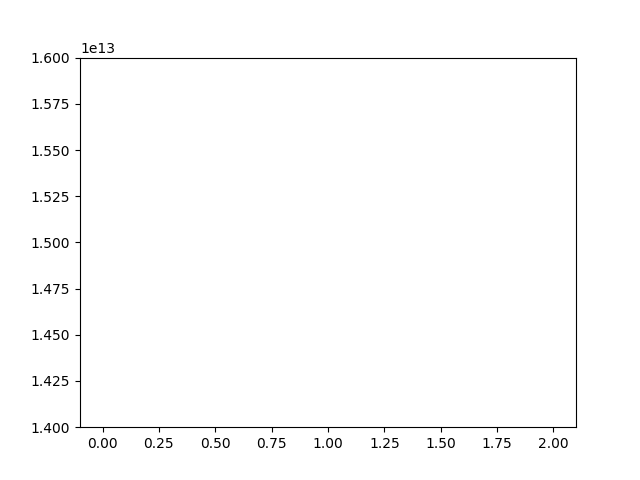

In [65]:
plt.plot(pos)
plt.ylim(1.4e13,1.6e13)
plt.show()

In [93]:
import numpy as np

In [94]:
dat = np.loadtxt('m31_data.txt', usecols=(1,2,3,4,5,6,7))

In [95]:
dat[:,6]

array([-301. , -193.1, -203.9, -139. ])